# Airbnb Analysis: Hosts, Location, Historical, Price and Amenities

In [1]:
# import modules
import os
import csv
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
import sys

# import modules for visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import seaborn as sns
import folium
import requests


In [2]:
# Add the path to the 'exploration' folder and import the module
sys.path.append(os.path.abspath("exploration ipynb"))
from config import geoapify_api_key

In [3]:
# create an Airbnb dataframe
airbnb_df = pd.read_csv('Resources/air bnb csv with edits.csv')
airbnb_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,host_identity_verified,instant_bookable,accommodates,amenities,...,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,27-06-2008,f,t,f,6,"[""Elevator"", ""Cable TV"", ""Air conditioning"", ""...",...,2.0,3.0,115,30,730,2,15-05-2016,0.02,1,216
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,16-09-2008,t,t,t,1,"[""Host greets you"", ""Elevator"", ""Air condition...",...,1.0,1.0,71,30,366,27,6/10/2020,0.35,2,360
2,2732,Zen Life at the Beach,3041,Yoga Priestess,17-09-2008,f,t,f,1,"[""Cooking basics"", ""Host greets you"", ""Smoke a...",...,1.0,1.0,155,1,180,21,27-12-2019,0.18,2,337
3,2864,* Beautiful Master Suite/Jacuzzi Tub/*,3207,Bernadine,25-09-2008,f,t,t,2,"[""Host greets you"", ""Air conditioning"", ""Carbo...",...,1.0,1.0,50,30,730,0,NaN,NaN,1,0
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,5/3/2009,t,t,f,2,"[""Lock on bedroom door"", ""Fire extinguisher"", ...",...,1.0,1.0,60,30,1125,310,29-04-2020,2.25,5,337


# Data Cleanup

In [4]:
# remove unnecessary columns
clean_airbnb_df = airbnb_df.drop(columns=['id', 'name', 'host_id', 'host_identity_verified', 'instant_bookable', 'accommodates',
       'amenities', 'latitude', 'longitude','room_type', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count'])

# change column names for clarity
clean_airbnb_df = clean_airbnb_df.rename(columns={'neighbourhood_group': 'metro'})
clean_airbnb_df = clean_airbnb_df.rename(columns={'neighbourhood':'city'})

# remove host sites where availability is 0/365 days
clean_airbnb_df = clean_airbnb_df[clean_airbnb_df['availability_365'] != 0]

# remove host sites where price is 0
clean_airbnb_df = clean_airbnb_df[clean_airbnb_df['price'] !=0]

# remove host sites where year is null
clean_airbnb_df = clean_airbnb_df.dropna(subset=['host_since'])

# change state names to abbreviations for easy visualization
# create a dictionary mapping state names to abbreviations
state_abbreviations = {
    'California': 'CA',
    'DC':'DC',
    'Florida': 'FL',
    'Hawaii':'HI',
    'Illinois': 'IL',
    'Nevada':'NV',
    'New York ':'NY',
    'Tennessee':'TN',
    'Washington':'WA'
}

# List of state names
state_names = ['California', 'DC', 'Florida', 'Hawaii', 'Illinois', 'Nevada','New York ', 'Tennessee', 'Washington']

# Convert state names to abbreviations
states = [state_abbreviations[state] for state in state_names]

# Apply the mapping to the 'State' column
clean_airbnb_df['State Abbreviation'] = clean_airbnb_df['State'].map(state_abbreviations)

# Modify the 'Metro Area' column to include the state name after the city name
clean_airbnb_df['metro'] = clean_airbnb_df['metro'] + ', ' + clean_airbnb_df['State Abbreviation']

# Drop the 'State' column
clean_airbnb_df =clean_airbnb_df.drop(columns=['State Abbreviation'])

# reformat dates
# Ensure 'host_since' is of string type
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].astype(str)

# Now convert to datetime, allowing for multiple formats
# replace '-' with '/' in the 'host_since' column to standardize the format
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].str.replace('-', '/')
clean_airbnb_df['host_since'] = pd.to_datetime(clean_airbnb_df['host_since'], dayfirst=True, errors='coerce')
clean_airbnb_df.head()

,host_name,host_since,host_is_superhost,State,metro,city,property_type,price,availability_365
0,Paolo,2008-06-27,f,California,"Los Angeles, CA",Culver City,Entire condominium,115,216
1,Chas.,2008-09-16,t,California,"Los Angeles, CA",Hollywood,Private room in apartment,71,360
2,Yoga Priestess,2008-09-17,f,California,"Los Angeles, CA",Santa Monica,Private room in apartment,155,337
4,Sanni,2009-03-05,t,California,"Los Angeles, CA",Del Rey,Private room in tiny house,60,337
5,Sanni,2009-03-05,t,California,"Los Angeles, CA",Del Rey,Private room in guesthouse,70,332


# Host Analysis

In [5]:
#Create a datafram
airbnb_df = pd.read_csv('Resources/air bnb csv with edits.csv')

## How have Airbnb hosts joining airbnb increased or decreased over time (by year)? 

C:\Users\mende\AppData\Local\Temp\ipykernel_22356\2676220939.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  airbnb_df['host_since'] = pd.to_datetime(airbnb_df['host_since'], dayfirst=False, errors='coerce')


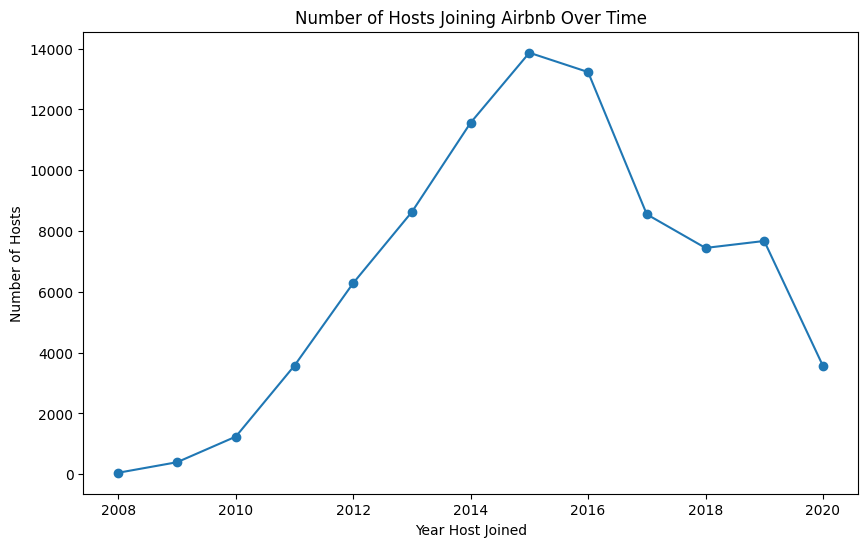

In [6]:
# Clean up host_since date format
# Reformat dates and ensure 'host_since' is of string type
airbnb_df['host_since'] = airbnb_df['host_since'].astype(str)

# Convert to datetime, allowing for multiple formats
# Replace '-' with '/' in the 'host_since' column to standardize the format
airbnb_df['host_since'] = airbnb_df['host_since'].str.replace('-', '/')
airbnb_df['host_since'] = pd.to_datetime(airbnb_df['host_since'], dayfirst=False, errors='coerce')

# Convert the host_since column to datetime
airbnb_df['host_since'] = pd.to_datetime(airbnb_df['host_since'], dayfirst=True, errors='coerce')

# Extract the year from host_since
airbnb_df['host_since_year'] = pd.DatetimeIndex(airbnb_df['host_since']).year

# Count the number of hosts who joined Airbnb each year
hosts_per_year = airbnb_df.groupby('host_since_year')['host_id'].nunique()

# Create a line chart
hosts_per_year.plot(kind='line', marker='o', figsize=(10, 6))

# Set title and labels
plt.title('Number of Hosts Joining Airbnb Over Time')
plt.xlabel('Year Host Joined')
plt.ylabel('Number of Hosts')

# Save plot as image file
plt.savefig("output_data/Fig1b.png")

# Show the chart
plt.show()

## What are the most popular Metro Areas to host in? What is the share of Hosts & Superhosts? 

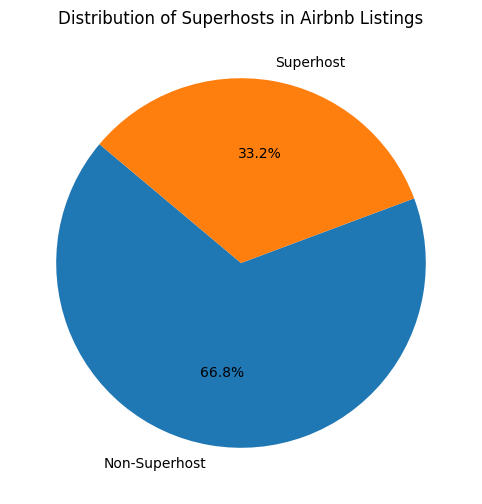

<Figure size 640x480 with 0 Axes>

In [7]:
# Count the number of Superhost and Non-Superhost listings
superhost_counts = airbnb_df['host_is_superhost'].value_counts()

# Plot as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(superhost_counts, labels=['Non-Superhost', 'Superhost'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Superhosts in Airbnb Listings')
plt.show()
plt.savefig("output_data/Fig4k.png")

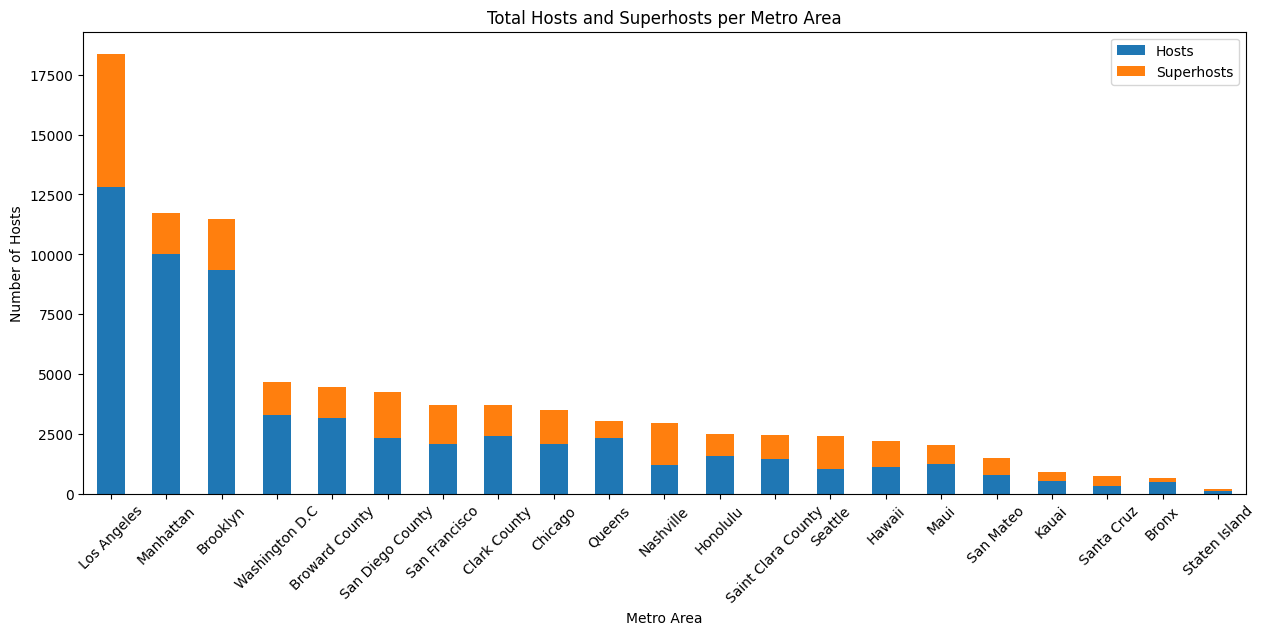

In [8]:
# Calculate the number of hosts per metro area
total_hosts_per_metro = airbnb_df.groupby("neighbourhood_group")["host_id"].nunique().sort_values(ascending=False)

# Number of Unique Hosts and Superhosts in each Metro
# Filter the dataset on the `host_is_superhost` column
superhosts_df = airbnb_df[airbnb_df['host_is_superhost'] == 't']
hosts_df = airbnb_df[airbnb_df['host_is_superhost'] == 'f']

# Count hosts superhosts in each neighborhood group
superhosts_per_metro = superhosts_df.groupby('neighbourhood_group')['host_id'].nunique().sort_values(ascending=False)
hosts_per_metro = hosts_df.groupby('neighbourhood_group')['host_id'].nunique().sort_values(ascending=False)

# Combine the results into a single DataFrame
combined_df = pd.DataFrame({
    'Total Hosts': total_hosts_per_metro,
    'Hosts': hosts_per_metro,
    'Superhosts': superhosts_per_metro
})

# Sort the DataFrame in descending order based on the total number of hosts
combined_df = combined_df.sort_values(by='Total Hosts', ascending=False)

# Plotting the bar chart
combined_df[['Hosts', 'Superhosts']].plot(kind='bar', stacked=True, figsize=(15, 6))

# Set the chart title and axis labels
plt.title('Total Hosts and Superhosts per Metro Area')
plt.xlabel('Metro Area')
plt.ylabel('Number of Hosts')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Save plot as image file
plt.savefig("output_data/Fig1a.png")

# Show the chart
plt.show()

## What are the most popular Property Types by Metro Area?

In [9]:
# Create a mapping dictionary to combine property types
property_type_mapping = {
    'Entire apartment': 'Entire Apartment',
    'Entire house': 'Entire House',
    'Entire guesthouse': 'Guesthouse',
    'Private room in house': 'Private Room',
    'Hotel Room': 'Hotel',
    'Condo': 'Entire Condominium',
    'Entire condominium': 'Entire Condominium',
    'Villa': 'Luxury',
    'Treehouse': 'Unique Stay',
    'Cabin': 'Unique Stay',
    'Boat': 'Unique Stay',
    'Hostel': 'Budget',
    'B&B': 'Hotel',
}

# Apply the mapping to create a new column in the DataFrame
airbnb_df['Property Type Grouped'] = airbnb_df['property_type'].map(property_type_mapping)

# Count the number of listings for each property type in each metro area
property_type_counts = airbnb_df.pivot_table(
    index='neighbourhood_group',
    columns='Property Type Grouped',
    aggfunc='size'
)

# Fill NaN values with 0
property_type_counts = property_type_counts.fillna(0)

# Reset the index to make 'neighbourhood_group' a column
property_type_counts = property_type_counts.reset_index()

# Melt the dataframe to long format
melted_df = property_type_counts.melt(
    id_vars=['neighbourhood_group'],
    var_name='Property Type Grouped',
    value_name='count'
)

# Rename the columns
melted_df.columns = ['Metro Area', 'Property Type Grouped', 'Count']

# Sort the melted DataFrame by 'Count' in descending order
melted_df = melted_df.sort_values(by='Count', ascending=False)

# Pivot the melted DataFrame to create a matrix for the heatmap
heatmap_data = melted_df.pivot_table(index='Property Type Grouped', columns='Metro Area', values='Count', fill_value=0)

# Sort the heatmap_data by the sum of each row in descending order
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=True).index]

# Create the heatmap using hvPlot with enlarged size
heatmap = heatmap_data.hvplot.heatmap(
    cmap='YlGnBu',  # Color map
    colorbar=True,  # Show color bar
    title='Heatmap of Property Types by Metro Area',
    xlabel='Metro Area',
    ylabel='Property Type',
    width=800,  # Adjust width
    height=600,  # Adjust height
)

# Show the heatmap with angled x-axis labels
heatmap.opts(xrotation=45)  # Rotate x-axis labels by 45 degrees

# Show the heatmap
heatmap

:HeatMap   [columns,index]   (value)

# Historical Analysis

In [10]:
# Load the dataset
df = pd.read_csv ('Resources/air bnb csv with edits.csv')

## Market Trends Over Time
### How have average prices for listings changed over the years in different cities or metro's?

C:\Users\mende\AppData\Local\Temp\ipykernel_22356\2526442039.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')


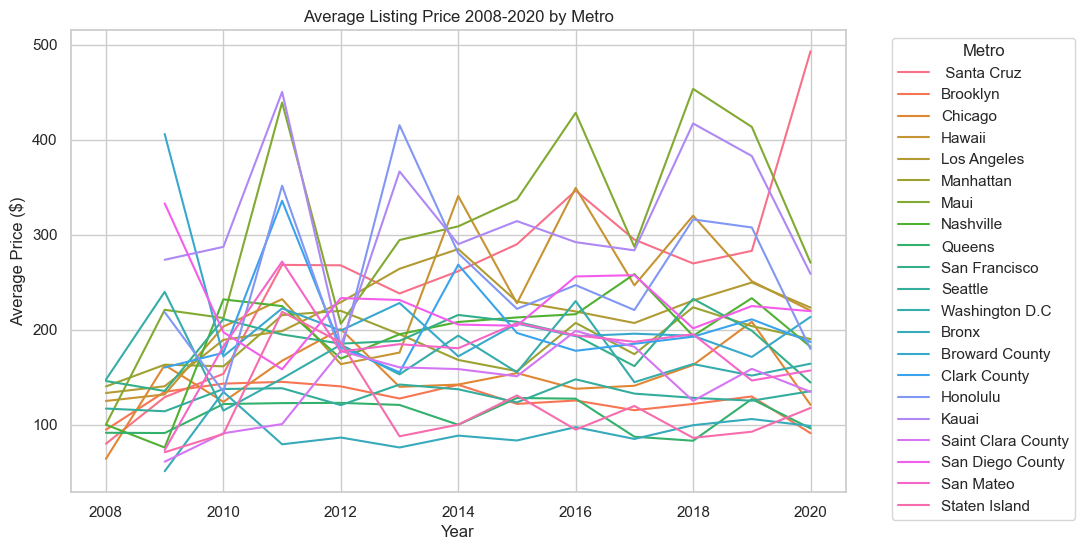

In [11]:
# Replace '-' with '/' to standardize the format (optional if needed)
df['host_since'] = df['host_since'].str.replace('-', '/')

# Convert 'host_since' directly to datetime with coercion for invalid parsing
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

# remove host sites where availability is 0/365 days
df = df[df['availability_365'] != 0]
df = df.rename(columns={'neighbourhood_group': 'Metro'})
df = df.rename(columns={'neighbourhood': 'City'})

# Display all unique cities in the dataframe
unique_cities = df['Metro'].unique()

# Optionally, you can display the cities as a list
city_list = unique_cities.tolist()

# Group by city and get unique latitude and longitude for each city
Metro_coordinates = df.groupby('Metro')[['latitude', 'longitude']].first().reset_index()

# Extract the year from the host_since or relevant date column
df['year'] = df['host_since'].dt.year

# Group by year and city/neighborhood, calculating the mean price
average_price_trends = df.groupby(['year', 'Metro'])['price'].mean().reset_index()

# Remove rows with NaN values (if necessary)
average_price_trends = average_price_trends.dropna(subset=['year', 'price'])

# Set the style
sns.set(style="whitegrid")

# Plot a line plot for each neighborhood over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_price_trends, x='year', y='price', hue='Metro')

# Customize the plot
plt.title('Average Listing Price 2008-2020 by Metro')
plt.xlabel('Year')
plt.ylabel('Average Price ($)')
plt.legend(title='Metro', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("output_data/LineFig2.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


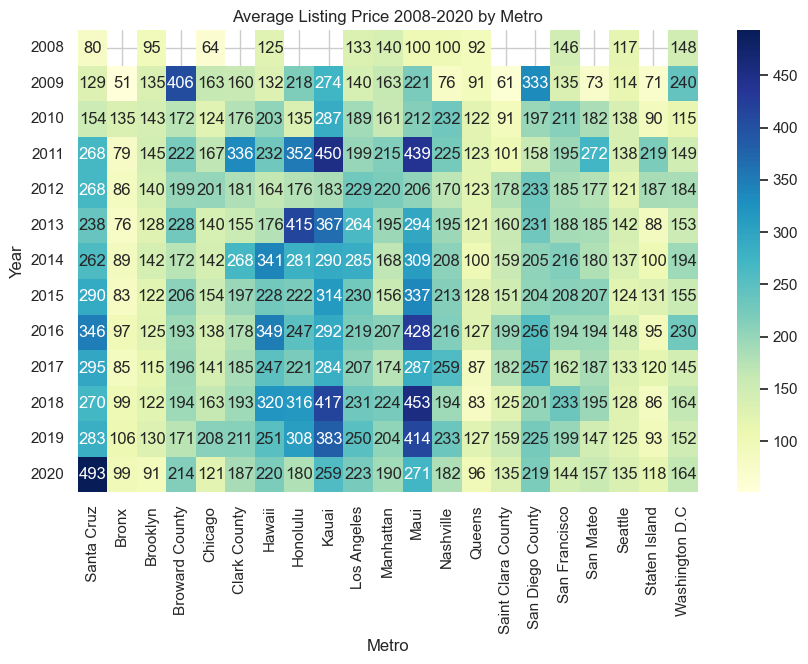

In [12]:
plt.figure(figsize=(10, 6))
pivot_table = average_price_trends.pivot(index='year', columns='Metro', values='price')

# Create the heatmap with annotations formatted to no decimals
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='YlGnBu')

# Update y-axis labels to display full 4-digit year values
# Ensure the y-ticks are displayed as 4-digit integers (e.g., 2012, 2013, ...)
plt.gca().set_yticklabels([str(int(year)) for year in pivot_table.index])

plt.title('Average Listing Price 2008-2020 by Metro')
plt.xlabel('Metro')
plt.ylabel('Year')

# Save plot as image file with 'tight' bounding box and increased dpi
plt.savefig("output_data/HeatmapFig1.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

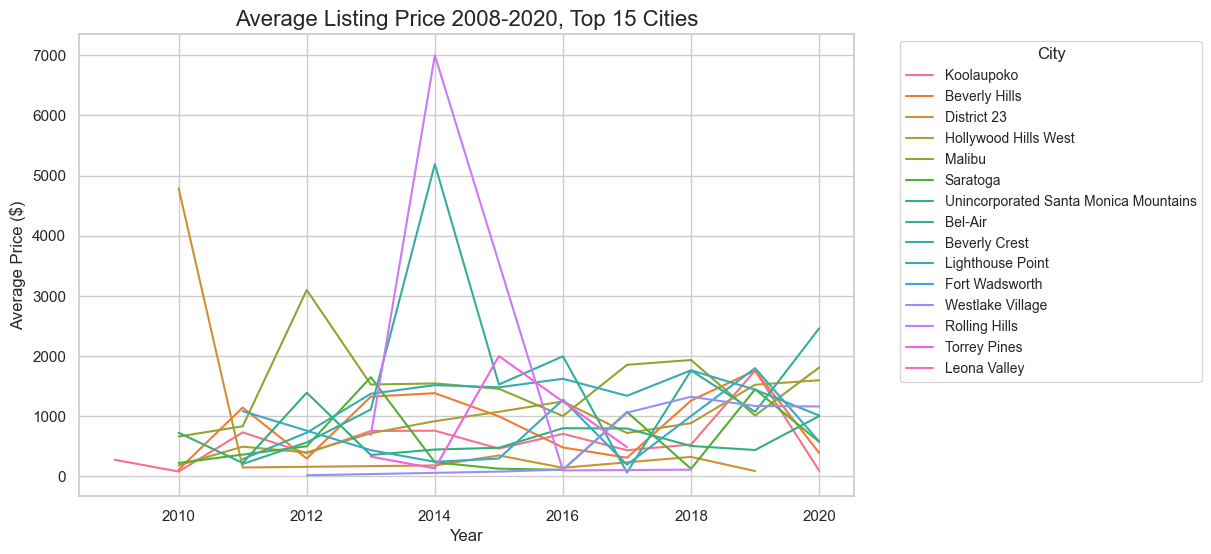

In [13]:
# Extract the year from the host_since or relevant date column
df['year'] = pd.to_datetime(df['host_since'], errors='coerce').dt.year  # Ensure 'host_since' is in datetime format

# Group by year and city/neighborhood, calculating the mean price
average_price_trends = df.groupby(['year', 'City'])['price'].mean().reset_index()

# Remove rows with NaN values (if necessary)
average_price_trends = average_price_trends.dropna(subset=['year', 'price'])

# Calculate the average price for each metro across all years
top_cities = average_price_trends.groupby('City')['price'].mean().sort_values(ascending=False).head(15).index

# Filter the data to only include the top 15 cities
top_cities_data = average_price_trends[average_price_trends['City'].isin(top_cities)]

# Set the style
sns.set(style="whitegrid")

# Plot a line plot for each neighborhood over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=top_cities_data, x='year', y='price', hue='City')

# Customize the plot
plt.title('Average Listing Price 2008-2020, Top 15 Cities', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Save the plot
plt.savefig("output_data/LineFig2_Top15.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


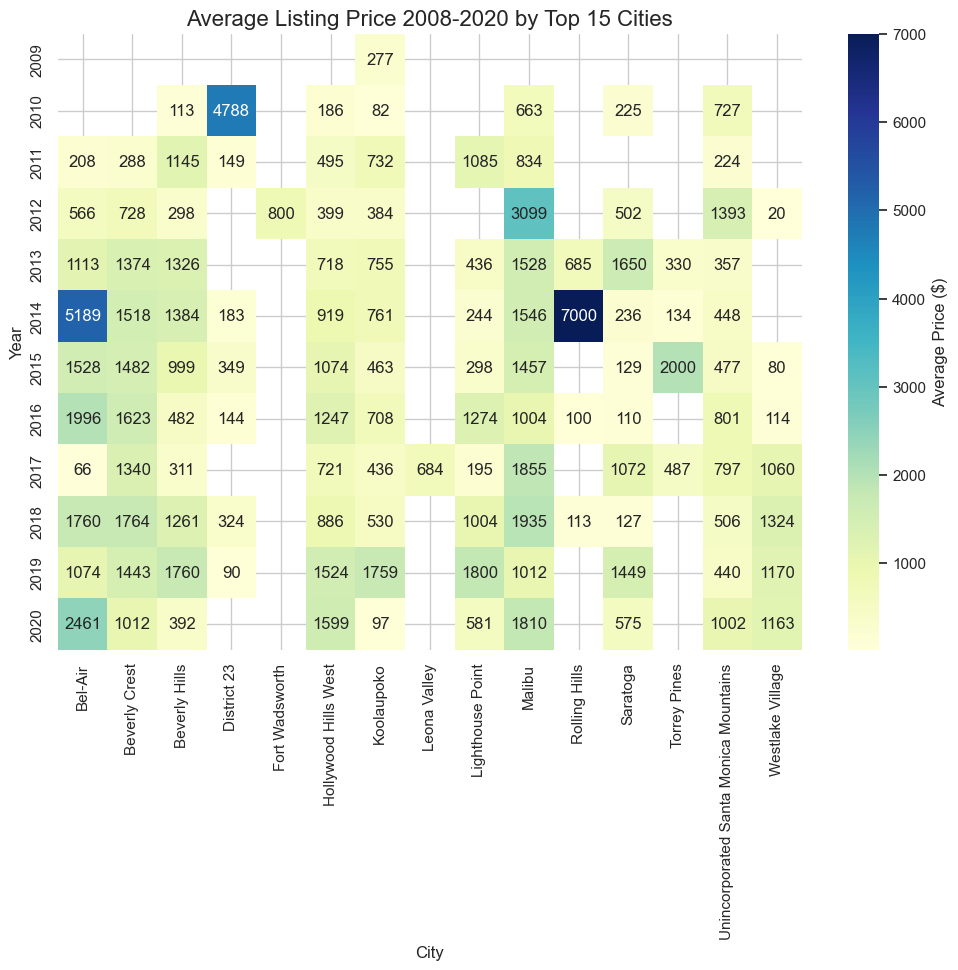

In [14]:
# Extract the year from the host_since or relevant date column
df['year'] = pd.to_datetime(df['host_since'], errors='coerce').dt.year  # Ensure 'host_since' is in datetime format

# Group by year and city, calculating the mean price
average_price_trends = df.groupby(['year', 'City'])['price'].mean().reset_index()

# Remove rows with NaN values (if necessary)
average_price_trends = average_price_trends.dropna(subset=['year', 'price'])

# Calculate the average price for each city across all years
top_cities = average_price_trends.groupby('City')['price'].mean().sort_values(ascending=False).head(15).index

# Filter the data to only include the top 15 cities
top_cities_data = average_price_trends[average_price_trends['City'].isin(top_cities)]

# Pivot the data to get a matrix format (City as columns, Year as rows)
pivot_table = top_cities_data.pivot(index='year', columns='City', values='price')

# Set the style for the heatmap
sns.set(style="whitegrid")

# Create the heatmap with annotations formatted to no decimals
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='YlGnBu', cbar_kws={'label': 'Average Price ($)'})

# Update y-axis labels to display full 4-digit year values
plt.gca().set_yticklabels([str(int(year)) for year in pivot_table.index])

# Customize the plot title and labels
plt.title('Average Listing Price 2008-2020 by Top 15 Cities', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Year', fontsize=12)

# Save the plot as an image file with 'tight' bounding box and increased dpi
plt.savefig("output_data/Heatmap_Top15_Cities.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [15]:
average_prices = df.groupby("Metro")["price"].mean().reset_index()

# Your data (City and average price)
data = [
    {"Metro": "Santa Cruz", "price": 287.237885},
    {"Metro": "Bronx", "price": 94.201044},
    {"Metro": "Brooklyn", "price": 127.695922},
    {"Metro": "Broward County", "price": 195.229724},
    {"Metro": "Chicago", "price": 154.750608},
    {"Metro": "Clark County", "price": 200.214749},
    {"Metro": "Hawaii", "price": 272.635874},
    {"Metro": "Honolulu", "price": 257.656375},
    {"Metro": "Kauai", "price": 324.682457},
    {"Metro": "Los Angeles", "price": 234.997259},
    {"Metro": "Manhattan", "price": 192.055952},
    {"Metro": "Maui", "price": 336.438732},
    {"Metro": "Nashville", "price": 214.506398},
    {"Metro": "Queens", "price": 108.557995},
    {"Metro": "Saint Clara County", "price": 157.533668},
    {"Metro": "San Diego County", "price": 226.518168},
    {"Metro": "San Francisco", "price": 195.444568},
    {"Metro": "San Mateo", "price": 187.808885},
    {"Metro": "Seattle", "price": 133.657290},
    {"Metro": "Staten Island", "price": 111.897872},
    {"Metro": "Washington D.C", "price": 174.407831}
]

# Create a DataFrame from the data
average_prices = pd.DataFrame(data)

# List of cities and their latitude/longitude
metro_data = [
    {"Metro": "Santa Cruz", "latitude": 36.9741, "longitude": -122.0308},
    {"Metro": "Bronx", "latitude": 40.8448, "longitude": -73.8648},
    {"Metro": "Brooklyn", "latitude": 40.6782, "longitude": -73.9442},
    {"Metro": "Broward County", "latitude": 26.1901, "longitude": -80.3659},
    {"Metro": "Chicago", "latitude": 41.8781, "longitude": -87.6298},
    {"Metro": "Clark County", "latitude": 36.0395, "longitude": -115.1645},
    {"Metro": "Hawaii", "latitude": 20.7984, "longitude": -156.3319},
    {"Metro": "Honolulu", "latitude": 21.3069, "longitude": -157.8583},
    {"Metro": "Kauai", "latitude": 22.0964, "longitude": -159.5261},
    {"Metro": "Los Angeles", "latitude": 34.0522, "longitude": -118.2437},
    {"Metro": "Manhattan", "latitude": 40.7831, "longitude": -73.9712},
    {"Metro": "Maui", "latitude": 20.7984, "longitude": -156.3319},
    {"Metro": "Nashville", "latitude": 36.1627, "longitude": -86.7816},
    {"Metro": "Queens", "latitude": 40.7282, "longitude": -73.7949},
    {"Metro": "Saint Clara County", "latitude": 37.3541, "longitude": -121.9552},
    {"Metro": "San Diego County", "latitude": 32.7157, "longitude": -117.1611},
    {"Metro": "San Francisco", "latitude": 37.7749, "longitude": -122.4194},
    {"Metro": "San Mateo", "latitude": 37.5629, "longitude": -122.3255},
    {"Metro": "Seattle", "latitude": 47.6062, "longitude": -122.3321},
    {"Metro": "Staten Island", "latitude": 40.5795, "longitude": -74.1502},
    {"Metro": "Washington D.C", "latitude": 38.9072, "longitude": -77.0369}
]

# Merge average prices with metro data based on the 'Metro' name
for metro in metro_data:
    # Use 'Metro' in metro_data to match with 'Metro' in average_prices dataframe
    matching_price = average_prices[average_prices['Metro'] == metro['Metro']]['price'].values
    if len(matching_price) > 0:
        metro['avg_price'] = matching_price[0]

# Create the map centered on a general location (New York as an example)
mymap = folium.Map(location=[40.7128, -74.0060], zoom_start=5)

# Add markers for each city with the average price
for metro in metro_data:
    price = metro.get('avg_price', None)
    if price:
        # Color based on price range
        color = 'green' if price < 150 else ('orange' if price < 250 else 'red')  
        folium.Marker(
            location=[metro['latitude'], metro['longitude']],
            popup=f"{metro['Metro']}<br>Average Price: ${price:.2f}",
            icon=folium.Icon(color=color)
        ).add_to(mymap)

# Save the map as an HTML file
mymap.save("output_data/geoapify_map_with_prices.html")

# Optionally, display the map in a Jupyter notebook
mymap


## Seasonality and Demand Patterns:
### Are there consistent peak and low seasons for Airbnb bookings in specific cities?

C:\Users\mende\AppData\Local\Temp\ipykernel_22356\668760913.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


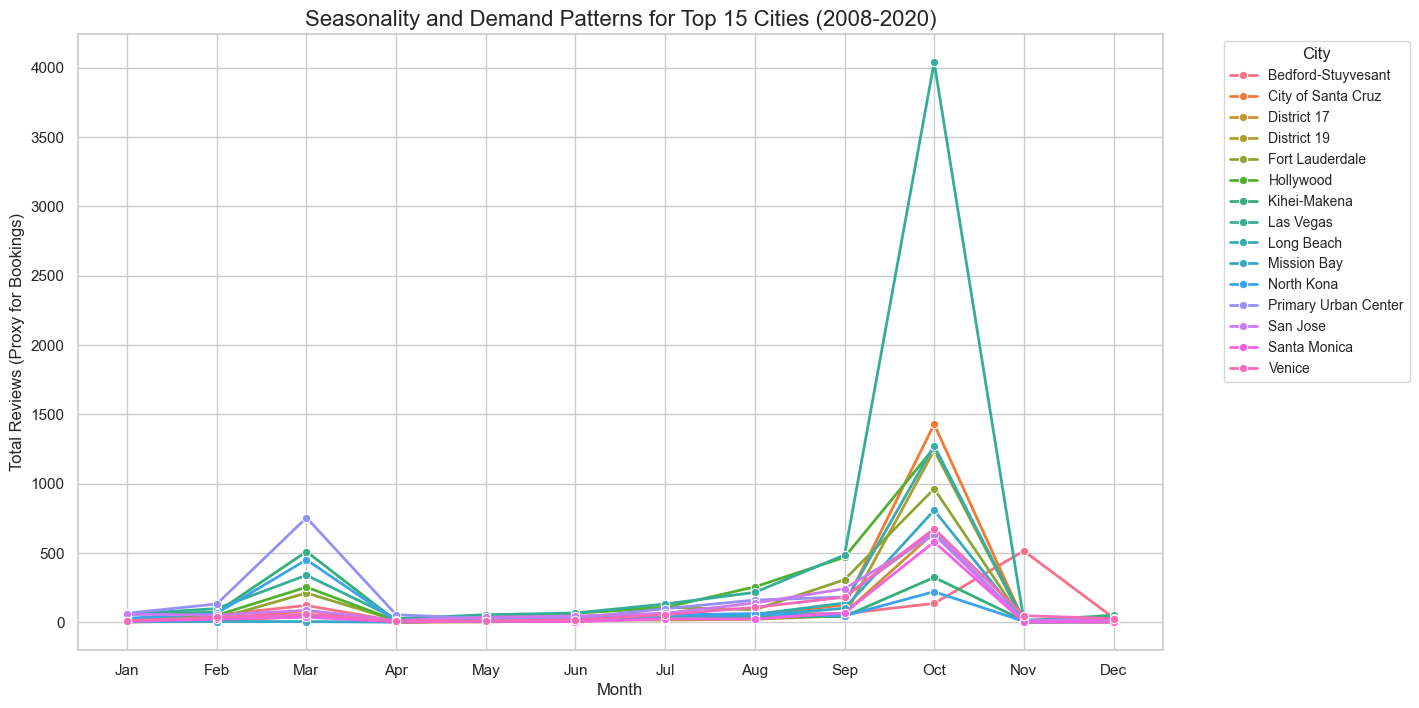

In [16]:
# Ensure 'last_review' is in datetime format
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# Filter the dataset to include only data from 2008 to 2020
df = df[(df['last_review'].dt.year >= 2008) & (df['last_review'].dt.year <= 2020)]

# Create a new column for the month of the review
df['month'] = df['last_review'].dt.month

# Group by 'City' and 'month' to get the total number of reviews per month for each city
monthly_data = df.groupby(['City', 'month']).agg({'reviews_per_month': 'sum'}).reset_index()

# Aggregate the total reviews for each city over the entire period
city_total_reviews = monthly_data.groupby('City')['reviews_per_month'].sum().reset_index()

# Sort the cities by total reviews in descending order and select the top 15
top_15_cities = city_total_reviews.sort_values(by='reviews_per_month', ascending=False).head(15)

# Filter the monthly_data to include only the top 15 cities
top_15_monthly_data = monthly_data[monthly_data['City'].isin(top_15_cities['City'])]

# Set up the figure size for better readability
plt.figure(figsize=(14, 8))

# Plot the data using seaborn lineplot for the top 15 cities
sns.lineplot(data=top_15_monthly_data, x='month', y='reviews_per_month', hue='City', marker='o', lw=2)

# Customizing the plot
plt.title('Seasonality and Demand Patterns for Top 15 Cities (2008-2020)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Reviews (Proxy for Bookings)', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)

plt.savefig("output_data/LineForSeasonsCity.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


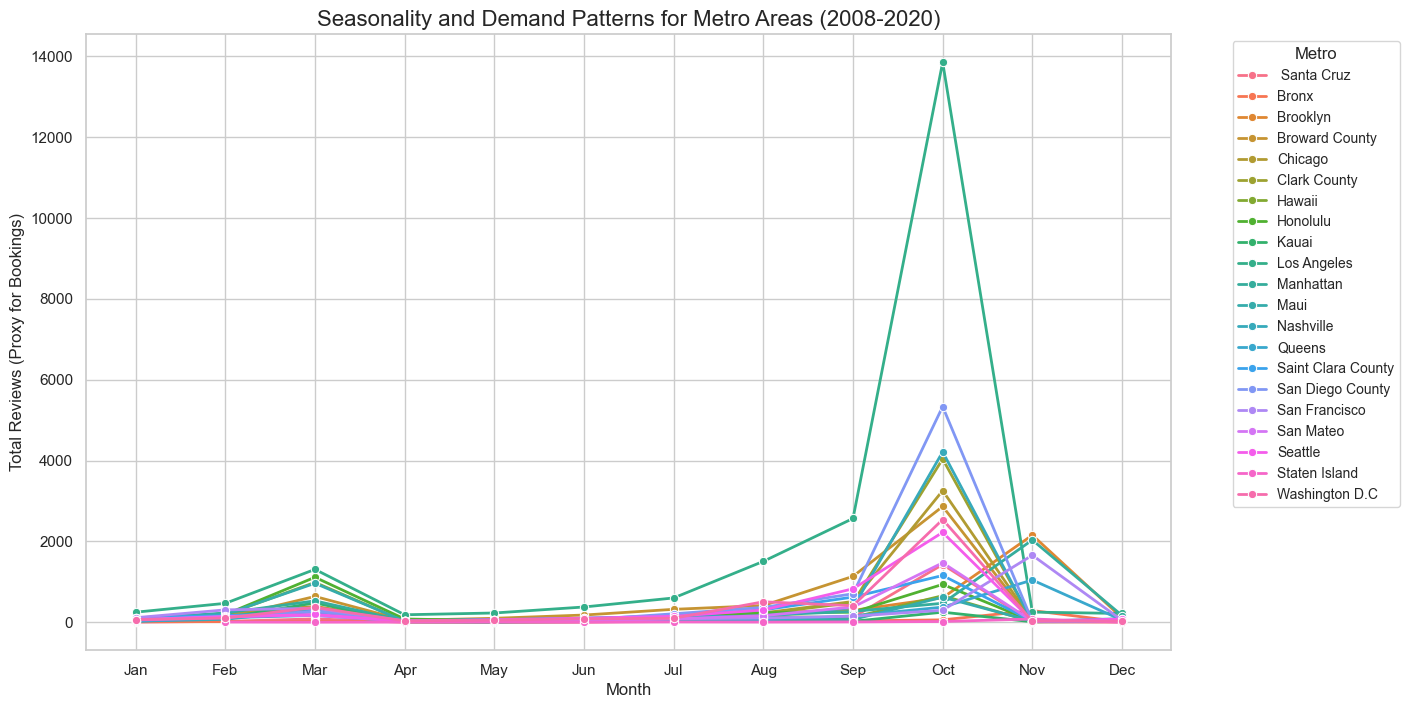

In [17]:
# Group by 'Metro' and 'month' to get the total number of reviews per month for each metro area
monthly_data = df.groupby(['Metro', 'month']).agg({'reviews_per_month': 'sum'}).reset_index()

# Set up the figure size for better readability
plt.figure(figsize=(14, 8))

# Plot the data using seaborn lineplot for all metro areas
sns.lineplot(data=monthly_data, x='month', y='reviews_per_month', hue='Metro', marker='o', lw=2)

# Customizing the plot
plt.title('Seasonality and Demand Patterns for Metro Areas (2008-2020)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Reviews (Proxy for Bookings)', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Metro', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)

plt.savefig("output_data/LineForSeasonsMetro.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

## Guest Preferences Over Time:
### How have guest preferences shifted over time in terms of property types (e.g., entire home/apartment vs. private room)?

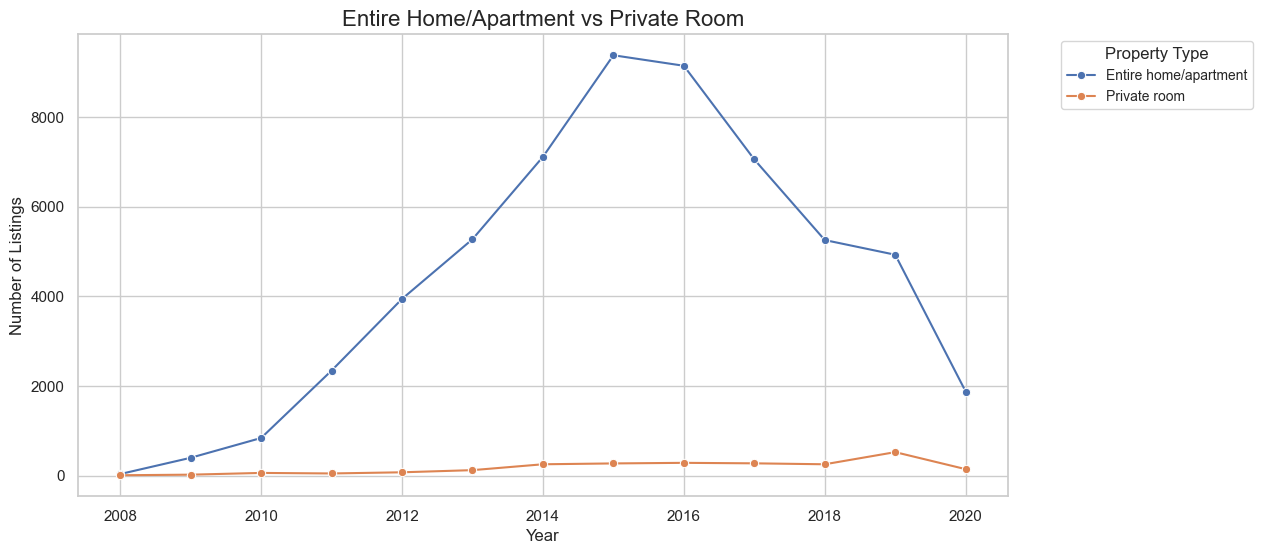

In [18]:
# Example property type mapping function
def clean_property_type(property_type):
    # Categories for entire home/apartment and private room
    entire_home_keywords = ['Entire', 'House', 'Apartment', 'Condominium', 'Guesthouse', 'Villa', 'Cottage', 'Chalet', 'Loft', 'Cabin', 'Bungalow', 'Suite', 'Flat', 'Serviced apartment', 'Vacation home', 'Timeshare', 'Floor']
    private_room_keywords = ['Private room', 'Room', 'Hostel', 'Hotel', 'Bungalow', 'Guesthouse', 'Treehouse', 'Castle', 'Resort', 'Yurt', 'Camper', 'RV', 'Tiny house', 'Bus', 'Boat', 'Farm stay', 'Tent', 'Earth house', 'Hut', 'Campsite']

    # Check for keywords and categorize accordingly
    property_type_lower = property_type.lower()  # make the comparison case insensitive
    if any(keyword.lower() in property_type_lower for keyword in entire_home_keywords):
        return 'Entire home/apartment'
    elif any(keyword.lower() in property_type_lower for keyword in private_room_keywords):
        return 'Private room'
    else:
        return 'Other'  # for cases that don't fit into either category

# Apply the cleaning function to the 'property_type' column
df['cleaned_property_type'] = df['property_type'].apply(clean_property_type)

# Ensure 'host_since' is in datetime format
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

# Create a new column for the year of the host's first listing
df['year'] = df['host_since'].dt.year

# Clean the property type column and categorize as 'Entire home/apartment' or 'Private room'
def clean_property_type(property_type):
    # Define keywords for categorization
    entire_home_keywords = ['Entire', 'House', 'Apartment', 'Condominium', 'Guesthouse', 'Villa', 'Cottage', 'Chalet', 'Loft', 'Cabin', 'Bungalow', 'Suite', 'Flat', 'Serviced apartment', 'Vacation home', 'Timeshare', 'Floor']
    private_room_keywords = ['Private room', 'Room', 'Hostel', 'Hotel', 'Bungalow', 'Guesthouse', 'Treehouse', 'Castle', 'Resort', 'Yurt', 'Camper', 'RV', 'Tiny house', 'Bus', 'Boat', 'Farm stay', 'Tent', 'Earth house', 'Hut', 'Campsite']

    # Check for keywords and categorize accordingly
    property_type_lower = property_type.lower()  # make the comparison case insensitive
    if any(keyword.lower() in property_type_lower for keyword in entire_home_keywords):
        return 'Entire home/apartment'
    elif any(keyword.lower() in property_type_lower for keyword in private_room_keywords):
        return 'Private room'

# Apply the cleaning function to the 'property_type' column
df['cleaned_property_type'] = df['property_type'].apply(clean_property_type)

# Group by year and the cleaned property type, calculating the number of listings
property_type_trends = df.groupby(['year', 'cleaned_property_type']).size().reset_index(name='listing_count')

# Set the style for the plot
sns.set(style="whitegrid")

# Create a line plot for the trends of "Entire home/apartment" vs "Private room"
plt.figure(figsize=(12, 6))
sns.lineplot(data=property_type_trends, x='year', y='listing_count', hue='cleaned_property_type', marker='o')

# Customize the plot
plt.title('Entire Home/Apartment vs Private Room', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.legend(title='Property Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.savefig("output_data/LineFigHomeVSRoom.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


# Price Analysis

# What are the least and most expensive rental prices and locations?
## Summary Statistics and Outliers
### Due to significant outliers, the median will provide the best average.

In [19]:
# summary statistics for Airbnb prices
clean_airbnb_df["price"].describe()

count    127860.000000
mean        209.162498
std         436.711102
min          10.000000
25%          79.000000
50%         125.000000
75%         209.000000
max       24999.000000
Name: price, dtype: float64

In [20]:
# what is the median price?
median_price = clean_airbnb_df['price'].median()
median_price

125.0

In [21]:
# Create a data frame showing median, min, max for each city
# Group by 'metro' and calculate median, min, and max prices
metro_price_stats_df = pd.DataFrame(clean_airbnb_df.groupby('metro')['price'].agg(['median', 'min', 'max']))

# Reset the index to turn the grouped index into a column
metro_price_stats_df = metro_price_stats_df.reset_index()

# Rename the columns for clarity
metro_price_stats_df.columns = ['Metro Area','Median Price', 'Min Price', 'Max Price']

# Remove white space around metro area names to sort properly
metro_price_stats_df['Metro Area'] = metro_price_stats_df['Metro Area'].str.strip()

# Sort values by metro area
metro_price_stats_df = metro_price_stats_df.sort_values(by='Metro Area', ascending=True)

# Display the resulting DataFrame
metro_price_stats_df

,Metro Area,Median Price,Min Price,Max Price
1,"Bronx, NY",68.0,20,2000
2,"Brooklyn, NY",95.0,10,4000
3,"Broward County, FL",121.0,12,10000
4,"Chicago, IL",99.0,10,10000
5,"Clark County, NV",129.0,13,10000
6,"Hawaii, HI",150.0,15,15000
7,"Honolulu, HI",145.0,10,24600
8,"Kauai, HI",239.0,49,4200
9,"Los Angeles, CA",117.0,10,21053
10,"Manhattan, NY",120.0,19,10000


<Figure size 1000x600 with 0 Axes>

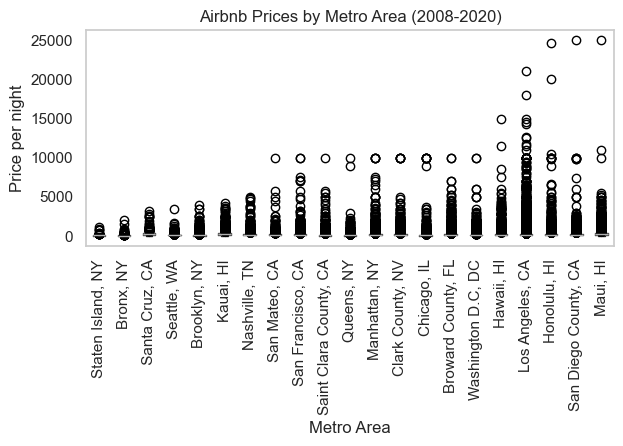

In [22]:
# create a boxplot to show the price range and outliers for each metro area

# Organize plot to display data with max values on the right
# Calculate the max price for each metro area
max_prices = clean_airbnb_df.groupby('metro', observed=False)['price'].max().sort_values()

# Create a new ordered categorical type for the metro areas based on the max prices
clean_airbnb_df['metro'] = pd.Categorical(clean_airbnb_df['metro'], categories=max_prices.index, ordered=True)

plt.figure(figsize=(10, 6))
clean_airbnb_df.boxplot(column='price', by='metro', grid=False)

plt.title('Airbnb Prices by Metro Area (2008-2020)')
plt.suptitle('')  # Suppress the default title to make it cleaner
plt.xlabel('Metro Area')
plt.ylabel('Price per night')
plt.xticks(rotation=90)
plt.tight_layout()

# Save plot as image file
plt.savefig("output_data/Fig3a.png")

plt.show()

<Figure size 1000x600 with 0 Axes>

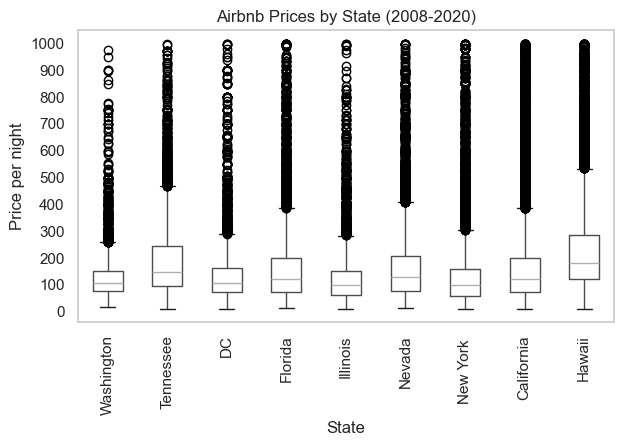

In [23]:
# Create a boxplot that removes extreme outliers
# Prices 1000/night and below BY STATE

# Organize plot to display data with max values on the right
# Calculate the max price for each state 
max_prices = clean_airbnb_df.groupby('State', observed=False)['price'].max().sort_values()

# Create a new ordered categorical type for the metro areas based on the max prices
clean_airbnb_df['State'] = pd.Categorical(clean_airbnb_df['State'], categories=max_prices.index, ordered=True)

# Filter data to remove extreme outliers (prices greater than a certain value)
filtered_df = clean_airbnb_df[clean_airbnb_df.price < 1000]

plt.figure(figsize=(10, 6))
filtered_df.boxplot(column='price', by='State', grid=False)

plt.title('Airbnb Prices by State (2008-2020)')
plt.suptitle('')  # Suppress the default title to make it cleaner

# Set y-axis increments
plt.yticks(range(0, 1100, 100))
#plt.axhline(y=125, color='r', linestyle='--')

plt.xlabel('State')
plt.ylabel('Price per night')
plt.xticks(rotation=90)
plt.tight_layout()

# Save plot as image file
plt.savefig("output_data/Fig3b.png")

plt.show()

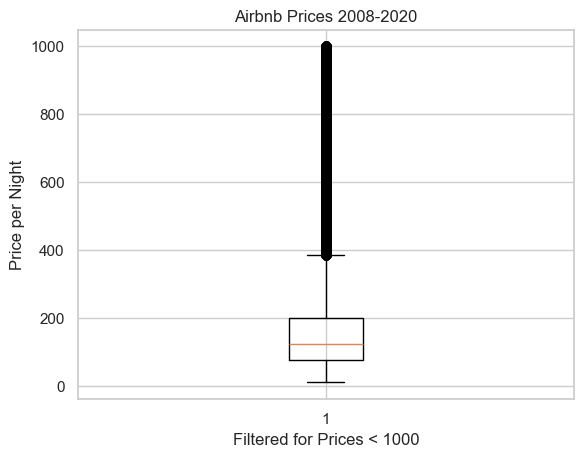

In [24]:
# Filter data to remove extreme outliers (prices greater than a certain value)
filtered_df = clean_airbnb_df[clean_airbnb_df.price < 1000]

# Create a boxplot using Matplotlib
plt.boxplot(filtered_df['price'])
plt.title('Airbnb Prices 2008-2020')
plt.ylabel('Price per Night')
plt.xlabel('Filtered for Prices < 1000')

# Save plot as image file
plt.savefig("output_data/Fig3c.png")

plt.show()

In [25]:
# What kinds of property are associated with the max values for each location?

In [26]:

# find the max price for each metro area
max_price_df = clean_airbnb_df.groupby('metro', observed=False)['price'].max().reset_index()
max_price_df.columns = ['metro', 'max_price']

# filter properties for prices greater than or equal to 15000
filter_max_properties = max_price_df[max_price_df['max_price'] >= 15000]
filter_max_properties

# merge the filter back into the original data frame
max_properties = clean_airbnb_df[clean_airbnb_df['price'].isin(filter_max_properties['max_price'])]

# Sort values by metro area, most expensive to least expensive
max_properties_df = max_properties.sort_values(by='price', ascending=False)

# Drop unncessary columns
max_properties_df = max_properties_df.drop(columns=['State'])

max_properties_df

,host_name,host_since,host_is_superhost,metro,city,property_type,price,availability_365
38104,SeaBreeze,2017-03-22,f,"San Diego County, CA",La Jolla,Entire house,24999,1
85754,Rentals Maui,2015-12-10,f,"Maui, HI",Kihei-Makena,Entire condominium,24999,217
80367,Karin,2018-04-24,f,"Honolulu, HI",North Shore Oahu,Entire villa,24600,365
10520,Marina,2014-11-07,f,"Los Angeles, CA",Bel-Air,Entire villa,21053,363
22310,Viceroy L’Ermitage,2019-09-20,f,"Los Angeles, CA",Beverly Hills,Room in boutique hotel,15000,196
84426,Kauhale,2018-11-23,f,"Hawaii, HI",South Kohala,Entire villa,15000,325


# What are the median and minimum prices for each metro area?

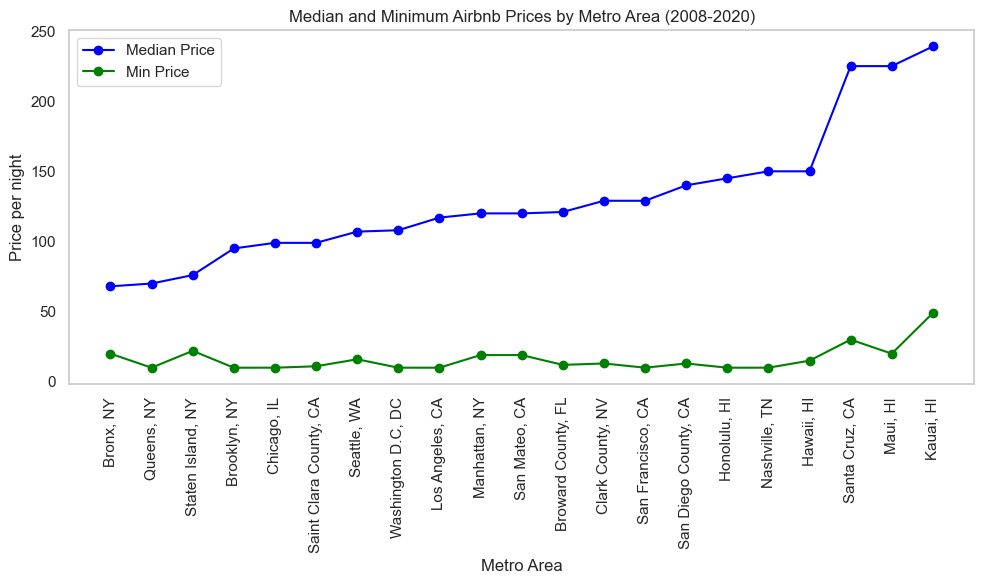

In [27]:
# create line graphs showing median and minimum prices for each metro area

# for clearer visualization, sort stats_df by median values
sorted_df_median = metro_price_stats_df.sort_values(by='Median Price')

# Extract the cities and corresponding prices
cities = sorted_df_median['Metro Area']
median_prices = sorted_df_median['Median Price']
min_prices = sorted_df_median['Min Price']

# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(cities, median_prices, color="blue", label="Median Price", marker='o')
plt.plot(cities, min_prices, color="green", label="Min Price", marker='o')

# Add titles and labels
plt.title("Median and Minimum Airbnb Prices by Metro Area (2008-2020)")
plt.xlabel("Metro Area")
plt.ylabel("Price per night")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid()

# Save plot as image file
plt.savefig("output_data/Fig3d.png")

# How did prices change between 2008 and 2020?

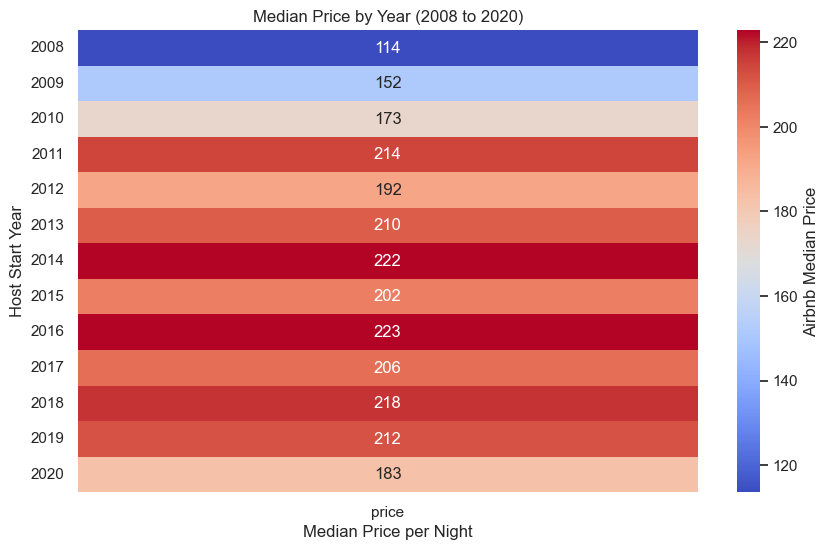

In [28]:
# extract the year from 'host_since' column
clean_airbnb_df['year'] = pd.to_datetime(clean_airbnb_df['host_since']).dt.year

# Convert year to integer
clean_airbnb_df['year'] = clean_airbnb_df['year'].astype(int)

median_price_df = clean_airbnb_df[['year', 'price']]

# Create a pivot table
pivot_table = median_price_df.pivot_table(values='price', index='year', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 6))  # Adjust size as needed
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.0f', cbar_kws={'label': 'Airbnb Median Price'})  # annot=True to display values

# Format heatmap
plt.title('Median Price by Year (2008 to 2020)')
plt.yticks(rotation=360)
plt.xlabel('Median Price per Night')
plt.ylabel('Host Start Year')

# Save plot as image file
plt.savefig("output_data/Fig3e.png")

# Amenities Analysis
## What are the most popular amenities?

In [29]:
import re
import json
from collections import Counter

# Load the CSV file with a relative path
file_path = 'Resources/air bnb csv with edits.csv'  # Relative path to the CSV file
df = pd.read_csv(file_path)

# Function to clean and parse the amenities column
def clean_and_parse_amenities(amenities_str):
    try:
        cleaned_str = re.sub(r'(\w+):', r'"\1":', amenities_str).replace("'", '"')
        return json.loads(cleaned_str)
    except (json.JSONDecodeError, ValueError):
        return []

# Apply the parsing function and flatten the list of amenities
all_amenities = [item for sublist in df['amenities'].apply(lambda x: clean_and_parse_amenities(x) if isinstance(x, str) else []) for item in sublist]

# Count the frequency of each unique amenity
amenities_counter = Counter(all_amenities)

# Get the 10 most common amenities
most_common_amenities = amenities_counter.most_common(10)

# Print the most popular amenities
print("The most popular amenities are:")
for amenity, count in most_common_amenities:
    print(f"{amenity}: {count} listings")


The most popular amenities are:
Wifi: 153989 listings
Essentials: 146827 listings
Smoke alarm: 144300 listings
Kitchen: 139559 listings
Hangers: 132614 listings
TV: 130571 listings
Heating: 126875 listings
Hair dryer: 124915 listings
Iron: 120742 listings
Air conditioning: 120480 listings


## How are amenities categorized? How do luxury amenities impact price?

Basic Amenities:
- Air conditioning: 120593 occurrences
- Kitchen: 139694 occurrences
- Heating: 126927 occurrences
- TV: 130640 occurrences
- Essentials: 146865 occurrences

Luxury Amenities:
- Pool: 41242 occurrences
- Gym: 29231 occurrences
- Hot tub: 26040 occurrences
- Sauna: 15 occurrences
- Outdoor dining area: 2 occurrences

Safety Amenities:
- Carbon monoxide alarm: 114107 occurrences
- Fire extinguisher: 87878 occurrences
- First aid kit: 66955 occurrences
- Smoke alarm: 144341 occurrences



<Figure size 640x480 with 0 Axes>

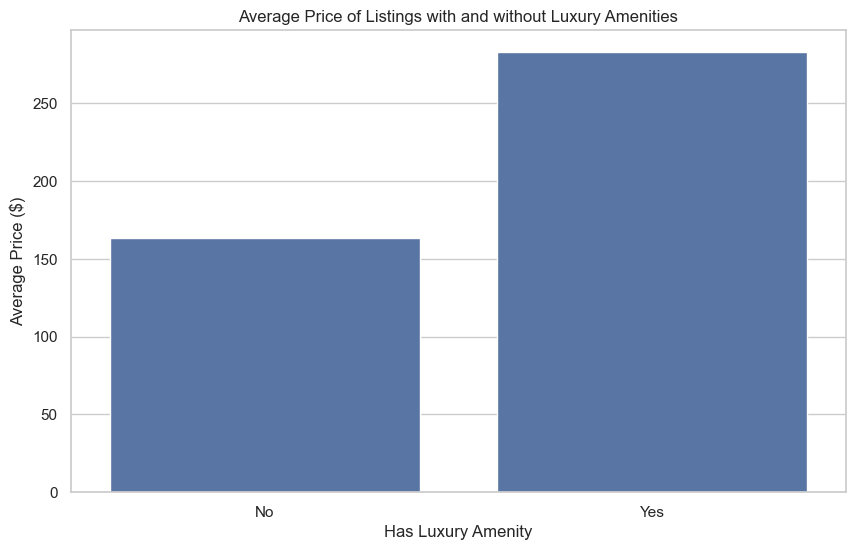

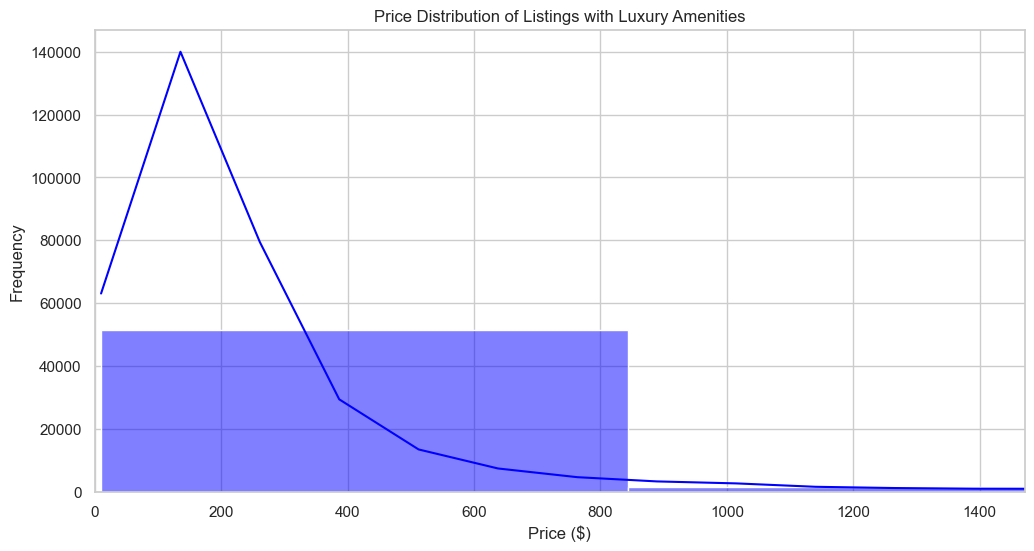

In [30]:
# Import necessary libraries
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = 'Resources/air bnb csv with edits.csv'
data = pd.read_csv(file_path)

# Extract amenities and clean the data
data['amenities'] = data['amenities'].apply(lambda x: x.strip('[]').replace('"', '').split(', '))
amenities_list = [amenity for sublist in data['amenities'] for amenity in sublist]

# Count the frequency of each amenity
amenities_count = Counter(amenities_list)

# Grouping amenities into categories
basic_amenities = ['WiFi', 'Kitchen', 'Heating', 'Air conditioning', 'TV', 'Essentials']
luxury_amenities = ['Hot tub', 'Pool', 'Sauna', 'Gym', 'Jacuzzi', 'Outdoor dining area']
safety_amenities = ['Smoke alarm', 'Carbon monoxide alarm', 'Fire extinguisher', 'First aid kit']

# Create a dictionary to store categorized amenities
categorized_amenities = {
    'Basic': {amenity: count for amenity, count in amenities_count.items() if amenity in basic_amenities},
    'Luxury': {amenity: count for amenity, count in amenities_count.items() if amenity in luxury_amenities},
    'Safety': {amenity: count for amenity, count in amenities_count.items() if amenity in safety_amenities}
}

# Analyze impact of luxury amenities on price
data['price'] = pd.to_numeric(data['price'].replace('[\$,]', '', regex=True))
data['has_luxury_amenity'] = data['amenities'].apply(lambda x: any(amenity in luxury_amenities for amenity in x))

# Compare average price of listings with and without luxury amenities
luxury_price_analysis = data.groupby('has_luxury_amenity')['price'].mean().reset_index()

# Display the categorized amenities
for category, amenities in categorized_amenities.items():
    print(f"{category} Amenities:")
    for amenity, count in amenities.items():
        print(f"- {amenity}: {count} occurrences")
    print()
#save plot as image file
plt.savefig("output_data/Fig4b.png")

# Plot the analysis
plt.figure(figsize=(10, 6))
sns.barplot(x='has_luxury_amenity', y='price', data=luxury_price_analysis)
plt.title('Average Price of Listings with and without Luxury Amenities')
plt.xlabel('Has Luxury Amenity')
plt.ylabel('Average Price ($)')
plt.xticks([0, 1], ['No', 'Yes'])

# Save plot as image file
plt.savefig("output_data/Fig4c.png")

plt.show()

# Visualize the price distribution for listings with luxury amenities
plt.figure(figsize=(12, 6))
sns.histplot(data[data['has_luxury_amenity'] == True]['price'], kde=True, color='blue', bins=30)
plt.title('Price Distribution of Listings with Luxury Amenities')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.xlim(0, data['price'].quantile(0.99))  # Set x-axis to show relevant price range up to the 99th percentile

# Save plot as image file
plt.savefig("output_data/Fig4d.png")

plt.show()


## Statistical analysis of price trends 

In [31]:
# Statistical analysis of price trends
luxury_prices = data[data['has_luxury_amenity'] == True]['price']
non_luxury_prices = data[data['has_luxury_amenity'] == False]['price']

# Perform t-test to compare means of listings with and without luxury amenities
t_stat, p_value = stats.ttest_ind(luxury_prices, non_luxury_prices, equal_var=False)
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("The difference in average price between listings with and without luxury amenities is statistically significant.")
else:
    print("The difference in average price between listings with and without luxury amenities is not statistically significant.")

NameError: name 'stats' is not defined

## Are the most expensive cities the same as the cities with the most luxury amenities? What cities have the most luxury amenities?

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

airbnb_df = pd.read_csv('Resources/air bnb csv with edits.csv')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


# Assuming 'data' DataFrame is defined and contains the necessary data

# Analysis of neighborhoods and luxury amenities
neighborhood_luxury_analysis = data.groupby('neighbourhood').agg(
    total_luxury_amenities=('has_luxury_amenity', 'sum'),
    average_price=('price', 'mean'),
    total_listings=('neighbourhood', 'size')
).reset_index()

# Calculate the percentage of listings with luxury amenities
neighborhood_luxury_analysis['luxury_amenity_percentage'] = (
    neighborhood_luxury_analysis['total_luxury_amenities'] / neighborhood_luxury_analysis['total_listings'] * 100
)

# Sort neighborhoods by total luxury amenities and average price
neighborhoods_most_luxury = neighborhood_luxury_analysis.sort_values(by='total_luxury_amenities', ascending=False)
neighborhoods_highest_prices = neighborhood_luxury_analysis.sort_values(by='average_price', ascending=False)

# Display top neighborhoods with the most luxury amenities and highest prices
most_luxury_styled = neighborhoods_most_luxury[['neighbourhood', 'total_luxury_amenities', 'luxury_amenity_percentage']].head(10).style \
    .background_gradient(subset=['total_luxury_amenities', 'luxury_amenity_percentage'], cmap='Purples') \
    .format({'luxury_amenity_percentage': "{:.1f}%"}).set_caption("Top 10 Neighborhoods by Luxury Amenities") \
    .set_properties(**{'font-size': '12pt', 'border': '1px solid black'})

highest_prices_styled = neighborhoods_highest_prices[['neighbourhood', 'average_price']].head(10).style \
    .background_gradient(subset=['average_price'], cmap='Greens') \
    .format({'average_price': "${:.2f}"}).set_caption("Top 10 Neighborhoods by Highest Prices") \
    .set_properties(**{'font-size': '12pt', 'border': '1px solid black'})

# Display both tables in a presentation-friendly style
print("Neighborhoods with the Most Luxury Amenities:")
display(most_luxury_styled)
plt.savefig("output_data/Fig4e.png")

print("Neighborhoods with the Highest Prices:")
display(highest_prices_styled)
plt.savefig("output_data/Fig4f.png")

# Define luxury_price if not already defined
if 'luxury_price' not in locals():
    luxury_price = neighborhood_luxury_analysis.copy()

# Define the output directory for saving images
output_dir = "output_data"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Assuming 'luxury_price' and 'neighborhood_luxury_analysis' DataFrames are defined and loaded with data

# Detailed comparison for top neighborhoods
top_neighborhoods = luxury_price[['neighbourhood', 'total_luxury_amenities', 'luxury_amenity_percentage', 'average_price']].head(10)

# Styling the DataFrame
styled_comparison_df = top_neighborhoods.style \
    .background_gradient(subset=['total_luxury_amenities', 'luxury_amenity_percentage', 'average_price'], cmap='Blues') \
    .format({'luxury_amenity_percentage': "{:.1f}%", 'average_price': "${:.2f}"}) \
    .set_caption("Top 10 Neighborhoods Luxury Comparison") \
    .set_properties(**{'font-size': '12pt', 'border': '1px solid black'})

# Display the detailed comparison table
print("Detailed Neighborhood Luxury Comparison:")
display(styled_comparison_df)

# Save the styled table as an image
plt.figure(figsize=(12, 8))
sns.heatmap(top_neighborhoods.set_index('neighbourhood'), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title("Top 10 Neighborhoods Luxury Comparison")
plt.savefig(os.path.join(output_dir, "4g.png"))  # Save the table visualization

# Visualization: Relationship between luxury amenities and average price by neighborhood with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='luxury_amenity_percentage', y='average_price', data=neighborhood_luxury_analysis, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Luxury Amenities Percentage vs Average Price by Neighborhood')
plt.xlabel('Luxury Amenity Percentage (%)')
plt.ylabel('Average Price ($)')
plt.grid(True)

# Save plot as image file in the output folder
plt.savefig(os.path.join(output_dir, "Fig4h.png"))

plt.show()

# Statistical correlation analysis between highest priced neighborhoods and neighborhoods with most luxury amenities
highest_price_neighborhoods = neighborhoods_highest_prices.head(10)['neighbourhood']
most_luxury_neighborhoods = neighborhoods_most_luxury.head(10)['neighbourhood']

# Calculate intersection of both sets
intersection_neighborhoods = set(highest_price_neighborhoods).intersection(set(most_luxury_neighborhoods))
intersection_count = len(intersection_neighborhoods)

print("Number of neighborhoods that are both in the top 10 highest priced and top 10 with most luxury amenities:")
print(intersection_count)

if intersection_count > 0:
    print("Neighborhoods that are both in the top 10 highest priced and top 10 with most luxury amenities:")
    print(intersection_neighborhoods)
else:
    print("There are no neighborhoods that are both in the top 10 highest priced and top 10 with most luxury amenities.")

## What are the top amenities by city?

In [ ]:
# Clean up amenities column
airbnb_df['amenities'] = airbnb_df['amenities'].str.replace('[\[\]"\'\s]', '', regex=True)

# Step 1: Extract amenities and group by neighborhood
airbnb_df['amenities_list'] = airbnb_df['amenities'].str.split(',')
sampled_neighborhoods = airbnb_df['neighbourhood'].value_counts().nlargest(10).index  # Select top 10 neighborhoods
filtered_df = airbnb_df[airbnb_df['neighbourhood'].isin(sampled_neighborhoods)]

# Count each amenity in each neighborhood
amenities_by_neighborhood = filtered_df.explode('amenities_list').groupby(['neighbourhood', 'amenities_list']).size().unstack(fill_value=0)

# Step 2: Get top 10 common amenities across all neighborhoods
top_amenities = amenities_by_neighborhood.sum().nlargest(10).index
top_amenities_df = amenities_by_neighborhood[top_amenities]

# Plot stacked bar chart with a professional color palette
top_amenities_df.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Pastel1')
plt.title('Top 10 Amenities by City')
plt.xlabel('City')
plt.ylabel('Count of Amenities')
plt.legend(title='Amenity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.savefig("output_data/Fig4i.png")

# Amenities count by city. 

In [ ]:
# Clean up amenities column
airbnb_df['amenities'] = airbnb_df['amenities'].str.replace('[\[\]"\'\s]', '', regex=True)

# Step 1: Extract amenities and group by neighborhood
airbnb_df['amenities_list'] = airbnb_df['amenities'].str.split(',')
sampled_neighborhoods = airbnb_df['neighbourhood'].value_counts().nlargest(10).index  # Select top 10 neighborhoods
filtered_df = airbnb_df[airbnb_df['neighbourhood'].isin(sampled_neighborhoods)]

# Count each amenity in each neighborhood
amenities_by_neighborhood = filtered_df.explode('amenities_list').groupby(['neighbourhood', 'amenities_list']).size().unstack(fill_value=0)

# Step 2: Get top 10 common amenities across all neighborhoods
top_amenities = amenities_by_neighborhood.sum().nlargest(10).index
top_amenities_df = amenities_by_neighborhood[top_amenities]

# Sort columns by neighborhood in ascending order
ordered_neighborhoods = sorted(top_amenities_df.index)  # Alphabetically sort the top neighborhoods
top_amenities_df = top_amenities_df.loc[ordered_neighborhoods]

# Plot heatmap with a subdued and professional color palette
plt.figure(figsize=(12, 8))
sns.heatmap(top_amenities_df.T, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='gray')
plt.title('Top 10 Amenities by City')
plt.xlabel('City')
plt.ylabel('Amenity')
plt.tight_layout()
plt.show()
plt.savefig("output_data/Fig4j.png")

# Price comparison between superhosts and non-superhosts. 

In [ ]:
# Convert price to numerical (if not already)
airbnb_df['price'] = pd.to_numeric(airbnb_df['price'], errors='coerce')

# Plot price distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_df, x='host_is_superhost', y='price')
plt.title('Price Comparison Between Superhosts and Non-Superhosts')
plt.xlabel('Superhost Status')
plt.ylabel('Price')
plt.xticks([0, 1], ['Non-Superhost', 'Superhost'])
plt.tight_layout()
plt.show()
plt.savefig("output_data/Fig4l.png")

# Price comparision of hosts vs superhosts adjusted for outliers. 

In [ ]:
# Convert price to numerical if needed
airbnb_df['price'] = pd.to_numeric(airbnb_df['price'], errors='coerce')

# Drop any rows with missing prices
airbnb_df = airbnb_df.dropna(subset=['price'])

# Set limits to focus on the central price range
price_limit = airbnb_df['price'].quantile(0.95)  # Set a 95th percentile limit to reduce outliers
filtered_df = airbnb_df[airbnb_df['price'] <= price_limit]

# Violin plot for price distribution without extreme outliers
plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x='host_is_superhost', y='price')
plt.title('Price Comparison: Superhosts vs. Non-Superhosts (95% Price Range)')
plt.xlabel('Superhost Status')
plt.ylabel('Price')
plt.xticks([0, 1], ['Non-Superhost', 'Superhost'])
plt.tight_layout()
plt.show()
plt.savefig("output_data/Fig4m.png")

# Total number of reviews superhosts vs non-superhosts

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert number_of_reviews to numerical if needed
airbnb_df['number_of_reviews'] = pd.to_numeric(airbnb_df['number_of_reviews'], errors='coerce')

# Plot total number of reviews for Superhosts vs. Non-Superhosts
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_df, x='host_is_superhost', y='number_of_reviews')
plt.title('Total Number of Reviews: Superhosts vs. Non-Superhosts')
plt.xlabel('Superhost Status')
plt.ylabel('Total Number of Reviews')
plt.xticks([0, 1], ['Non-Superhost', 'Superhost'])
plt.tight_layout()
plt.show()
plt.savefig("output_data/Fig4n.png")

# Monthly Review Frequency: Superhosts vs Non-Superhosts

In [ ]:
# Convert reviews_per_month to numerical if needed
airbnb_df['reviews_per_month'] = pd.to_numeric(airbnb_df['reviews_per_month'], errors='coerce')

# Plot monthly review frequency
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_df, x='host_is_superhost', y='reviews_per_month')
plt.title('Monthly Review Frequency: Superhosts vs. Non-Superhosts')
plt.xlabel('Superhost Status')
plt.ylabel('Reviews Per Month')
plt.xticks([0, 1], ['Non-Superhost', 'Superhost'])
plt.tight_layout()
plt.show()
plt.savefig("output_data/Fig4o.png")
